In [1]:
import pandas as pd
import numpy as np
import tqdm as tqdm
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
import os
import pickle
import numpy as np
import librosa

In [3]:
import src.model
import src.audio_feature

In [4]:
from src.helpers import parse_metadata, select_features, get_model_stats, prediction_df
from src.helpers import visualize_predictions

## Read in the data

In [14]:
metadata = parse_metadata('data/UrbanSound8K/metadata/UrbanSound8K.csv')

audio_features = []

for line in metadata:
    path, fold, label = line[0], line[1], line[2]
    
    

    fn = path.replace(".wav", "")
    transformed_path = f"{Path.home()}/Desktop/gal_notes/Capstone/Urban_sound_classification/pkl/fold{fold}/{fn}.pkl"

    if os.path.isfile(transformed_path):
        # if the file exists as a .pkl already, then load it
        with open(transformed_path, "rb") as f:
            audiofeatures = pickle.load(f)
            audio_features.append(audiofeatures)
    else:
        # if the file doesn't exist, then extract its features from the source data and save the result
        src_path = f"{Path.home()}/Desktop/gal_notes/Capstone/Urban_sound_classification/data/UrbanSound8K/audio/fold{fold}/{path}"
        # get features
        audio = src.audio_feature.AudioFeature(src_path, fold, label)
        
        audio.get_features("mfcc", "bw", "rolloff", "spec_cent", 
                           "zcr", "spectral", "chroma")
        
        audio_features.append(audio)
    
feature_matrix = np.vstack([audio.features for audio in audio_features])
labels = np.array([audio.label for audio in audio_features])
folds = np.array([audio.fold for audio in audio_features])

model_cfg = dict(
    model=RandomForestClassifier(
        random_state=42,
        n_jobs=10,
        class_weight="balanced",
        n_estimators=500,
        bootstrap=True,
    )
)

In [6]:
def get_model_stats(features_to_test, feature_matrix):
    testing_features = []

    for single_audio in feature_matrix:
        ## get the selected chosen features in each preloaded feature matrix entry
        single_chosen_features = select_features(features_to_test, single_audio)
        testing_features.append(single_chosen_features)

    ## fit the model
    testing_features = np.array(testing_features)
    model = src.model.Model(testing_features, labels, folds, model_cfg)
    fold_acc, predicted_labels, actual_labels = model.train_kfold()
    
    return fold_acc, predicted_labels, actual_labels

In [27]:
# "mfcc", "bw", "rolloff", "spec_cent", "zcr", "spectral", "chroma"
# bw bad
my_model = get_model_stats(['mfcc', 'spectral', 'zcr'], feature_matrix)

In [32]:
scores = {
    
}
feature_list = ['mfcc', 'bw', 'rolloff', 'spec_cent', 'zcr', 'spectral', 'chroma']
for feature in feature_list:
    print(feature)
    my_model = get_model_stats(feature, feature_matrix)
    scores[feature] = np.array(my_model[0]).mean()

mfcc
bw
rolloff
spec_cent
zcr
spectral
chroma


In [33]:
scores

{'mfcc': 0.6484125819855884,
 'bw': 0.2521876747822406,
 'rolloff': 0.26133554234659184,
 'spec_cent': 0.2535432179007037,
 'zcr': 0.2127651799014209,
 'spectral': 0.45365349734157706,
 'chroma': 0.45896310017182246}

In [34]:
mfcc_model = get_model_stats('mfcc', feature_matrix)

In [84]:
len(mfcc_model[2])

10

# Taken from my vscode - didn't want to reload

In [87]:
def prediction_df(predicted_labels, actual_labels):
    class_ids = {
        0: 'air_conditioner',
        1: 'car_horn',
        2: 'children_playing',
        3: 'dog_bark',
        4: 'drilling',
        5: 'engine_idling',
        6: 'gun_shot',
        7: 'jackhammer',
        8: 'siren',
        9: 'street_music'
    }

    list_to_df = []
    for i in range(len(predicted_labels)):
        actual_class = ''
        predicted_class = ''
        class_id = 0
        fold = i
    
    
        ## get an array of 0s and 1s where wrong predictions occured
        diff = predicted_labels[i] - actual_labels[i]
        diff[diff != 0] = 1
        ##
        for j in range(len(diff)):
            if diff[j] == 1:
                actual_class = actual_labels[i][j]
                actual_name = class_ids[actual_class]
                predicted_class = predicted_labels[i][j]
                predicted_name = class_ids[predicted_class]
                
                list_to_df.append([actual_class, actual_name,
                                predicted_class, predicted_name,
                                fold])
            

    wrong_preds = pd.DataFrame(list_to_df, columns=['actual_class', 'actual_name',
                                                    'predicted_class', 'predicted_name',
                                                    'fold'])
    return wrong_preds

In [91]:
df = prediction_df(mfcc_model[1], mfcc_model[2])

In [93]:
met = pd.read_csv('data/UrbanSound8K/metadata/UrbanSound8K.csv')
total_counts = met[['class', 'fold']].groupby('class').agg('count').sort_index()
num_mislabeled = df[['actual_name', 
                     'fold']].groupby('actual_name').agg('count').sort_index()
num_falsely_labeled = df[['predicted_name', 
                          'fold']].groupby('predicted_name').agg('count').sort_index()

accuracy = ((total_counts-num_mislabeled) / total_counts).sort_values('fold')
percentage_mislabeled = (num_mislabeled / total_counts).sort_values('fold')
percentage_falsely_labeled = (num_falsely_labeled / total_counts).sort_values('fold')

In [115]:
# accuracy.rename(columns={'fold': 'accuracy'})
rf_mfcc_df = accuracy
rf_mfcc_df['percent_mislabeled'] = percentage_mislabeled['fold']
rf_mfcc_df['percentage_falsely_labeled'] = percentage_falsely_labeled['fold']
rf_mfcc_df['total_counts'] = total_counts['fold']
rf_mfcc_df.drop(columns=['fold'], inplace=True)

In [117]:
ls

Capstone3_dataprep.ipynb  data/                     src/
Capstone3_nn.ipynb        flask_app/
README.md                 pkl/


In [118]:
rf_mfcc_df.to_pickle("models/rf_mfcc_df.pkl")

In [119]:
dff = pd.read_pickle('models/rf_mfcc_df.pkl')
dff.head()

,accuracy,percent_mislabeled,percentage_falsely_labeled,total_counts
class,,,,
air_conditioner,0.463000,0.537000,0.290000,1000
car_horn,0.517483,0.482517,0.111888,429
engine_idling,0.566000,0.434000,0.392000,1000
jackhammer,0.597000,0.403000,0.505000,1000
drilling,0.623000,0.377000,0.610000,1000


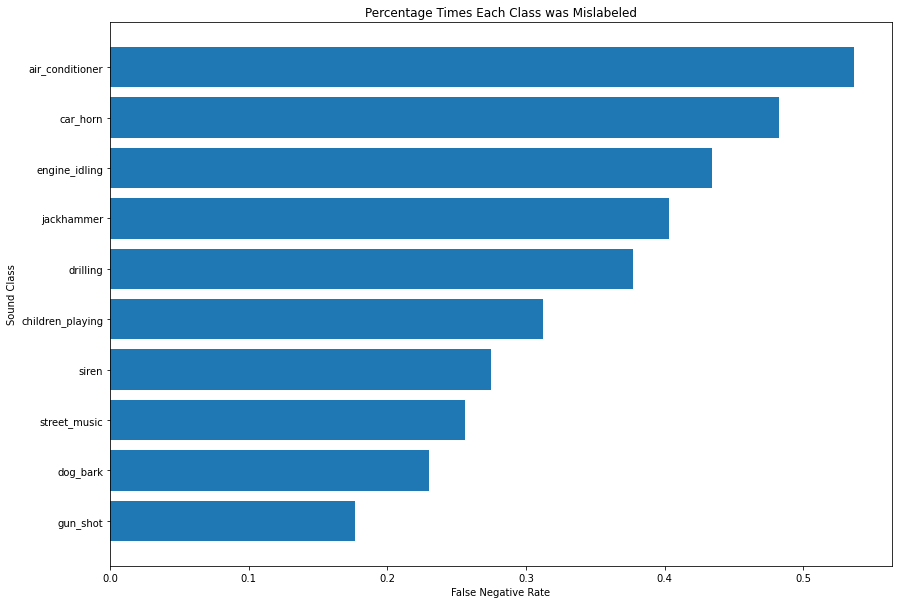

In [94]:
fig, ax = plt.subplots(figsize=(14,10))


ax.barh(percentage_mislabeled.index, percentage_mislabeled['fold'])
ax.set_title('Percentage Times Each Class was Mislabeled')
ax.set_xlabel('False Negative Rate')
ax.set_ylabel('Sound Class');

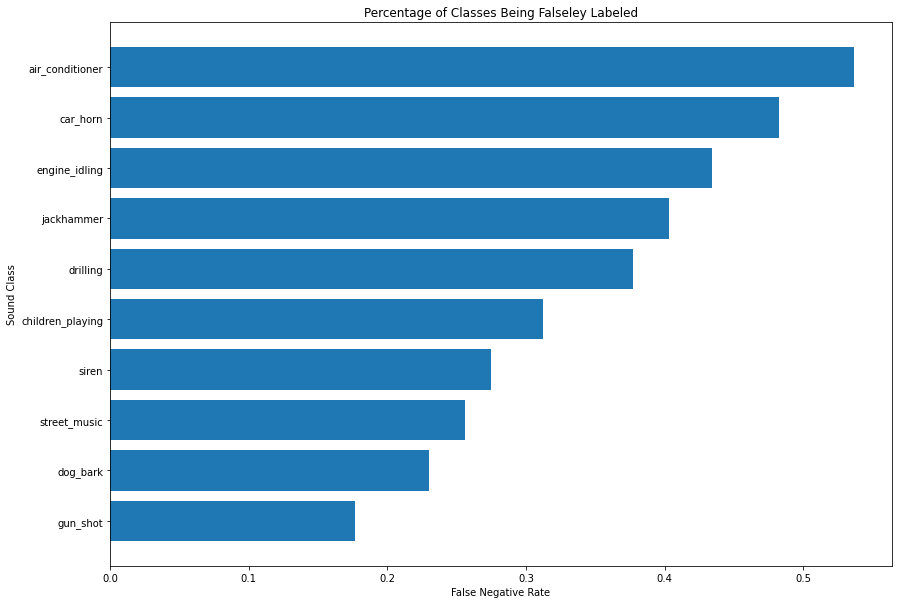

In [96]:
fig, ax = plt.subplots(figsize=(14,10))


ax.barh(percentage_mislabeled.index, percentage_mislabeled['fold'])
ax.set_title('Percentage of Classes Being Falseley Labeled')
ax.set_xlabel('False Negative Rate')
ax.set_ylabel('Sound Class');

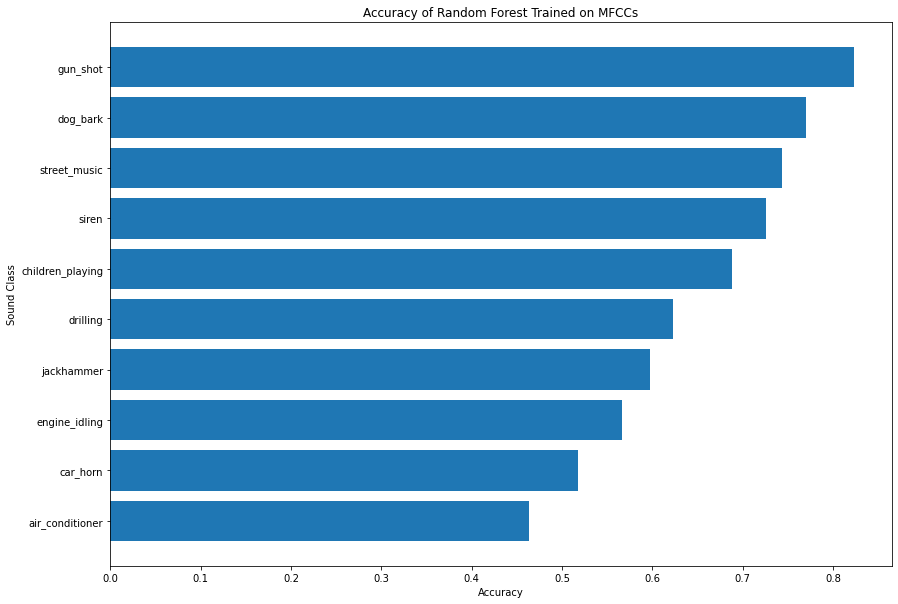

In [99]:
## Accuracy
fig, ax = plt.subplots(figsize=(14,10))


ax.barh(accuracy.index, accuracy['fold'])
ax.set_title('Accuracy of Random Forest Trained on MFCCs')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Sound Class');

In [98]:
met = pd.read_csv('data/UrbanSound8K/metadata/UrbanSound8K.csv')
total_counts = met[['class', 'fold']].groupby('class').agg('count')
total_counts.sort_index()

,fold
class,
air_conditioner,1000
car_horn,429
children_playing,1000
dog_bark,1000
drilling,1000
engine_idling,1000
gun_shot,374
jackhammer,1000
siren,929


In [49]:
met = pd.read_csv('data/UrbanSound8K/metadata/UrbanSound8K.csv')
total_counts = met[['class', 'fold']].groupby('class').agg('count')
percentage_mislabeled = (bars.sort_index() / total_counts.sort_index()).sort_values('fold')
percentage_mislabeled

,fold
actual_name,
gun_shot,0.008021
engine_idling,0.012000
street_music,0.021000
jackhammer,0.022000
dog_bark,0.023000
drilling,0.027000
air_conditioner,0.029000
children_playing,0.029000
car_horn,0.034965


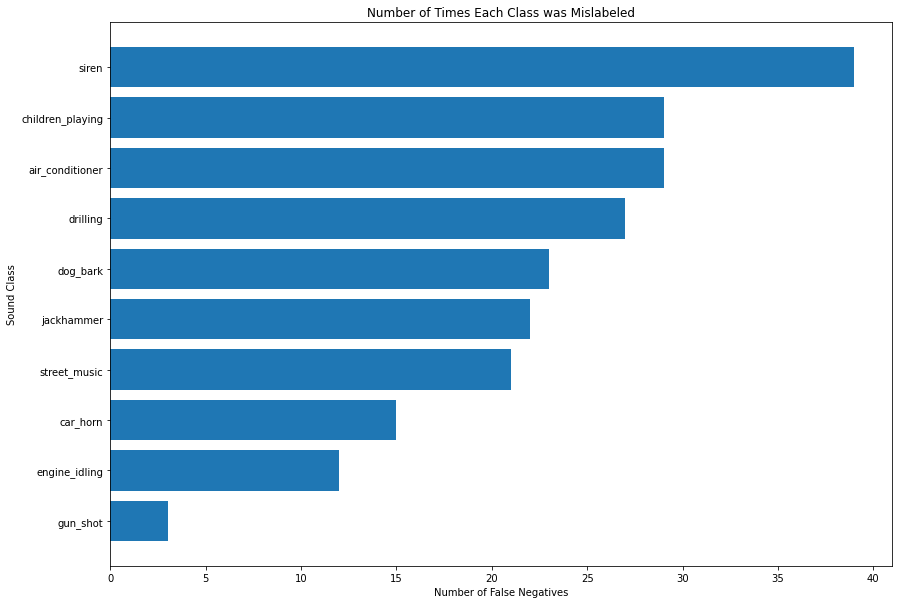

In [36]:
visualize_predictions(df, false_negatives=True)

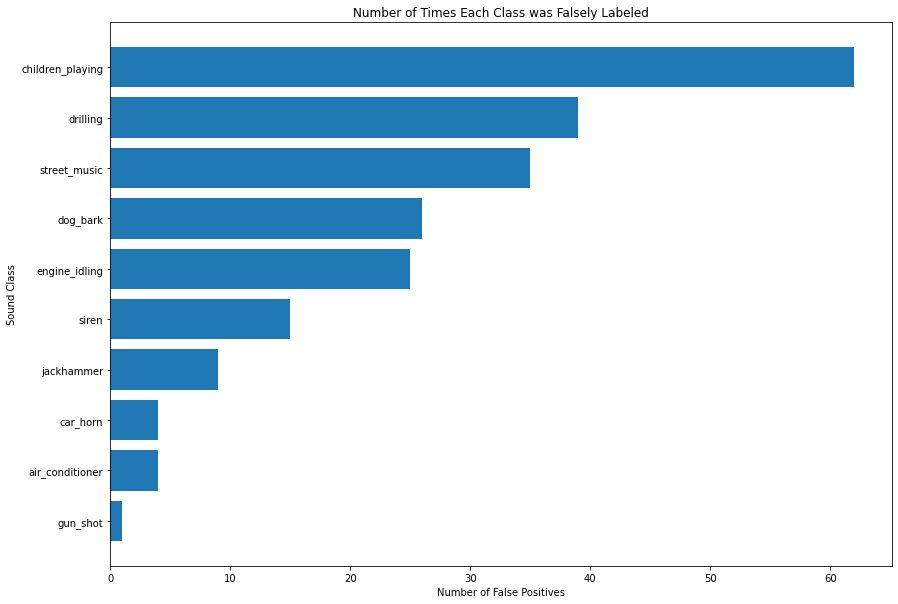

In [37]:
visualize_predictions(df, false_positives=True)

## Let's look at what sounds were hardest to predict

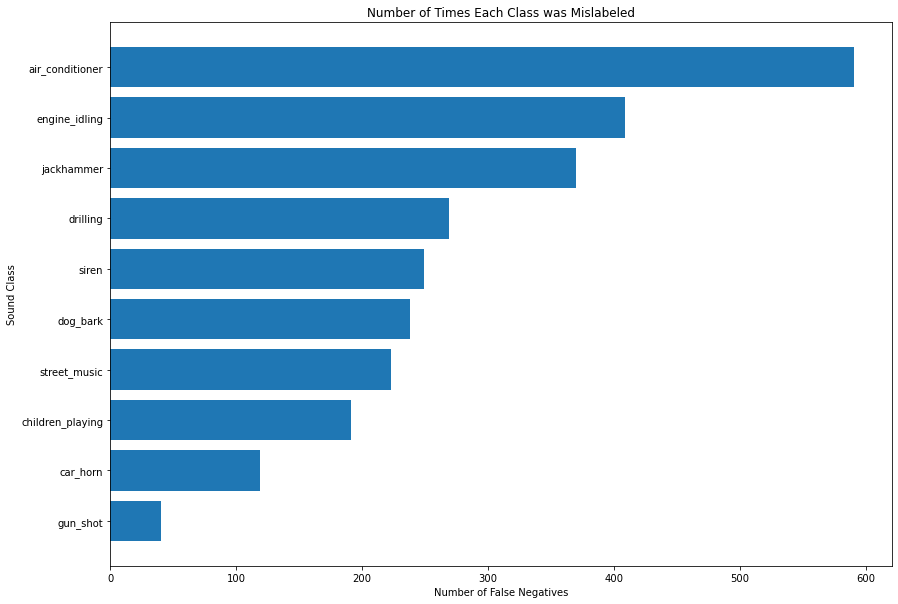

In [152]:
## Visualizing number of classes that weren't predicted
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14,10))
bars = wrong_preds[['actual_name', 
                    'fold']].groupby('actual_name').agg('count').sort_values('fold')

ax.barh(bars.index, bars['fold'])
ax.set_title('Number of Times Each Class was Mislabeled')
ax.set_xlabel('Number of False Negatives')
ax.set_ylabel('Sound Class');

## Visualize the classes that were falsely predicted

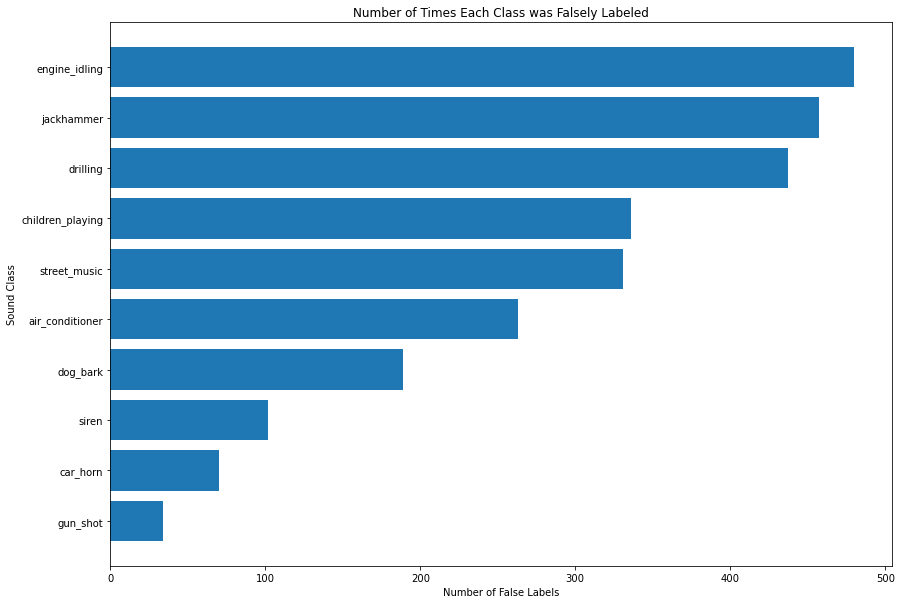

In [155]:
fig, ax = plt.subplots(figsize=(14,10))
bars = wrong_preds[['predicted_name', 
                    'fold']].groupby('predicted_name').agg('count').sort_values('fold')

ax.barh(bars.index, bars['fold'])
ax.set_title('Number of Times Each Class was Falsely Labeled')
ax.set_ylabel('Sound Class')
ax.set_xlabel('Number of False Positives');

# Let's cycle through different permutations of features and see wat gives the best predictions

### feature matrix has 90 elements

- 50 = mfccs
- 2  = spectral bandwidth
- 2  = rolloff
- 2  = spectral centroid
- 2  = zcr
- 8  = spectral contrast
- 24 = chroma

In [291]:
# chosen_features = ['mfc', 'spec_cent', 'rolloff', 'bw', 'zcr', 'spectral', 'chroma']
my_model = get_model_stats(['mfc', 'zcr', 'chroma'], feature_matrix)

In [281]:
my_model[0]

[0.6701030927835051,
 0.6959459459459459,
 0.6421621621621622,
 0.6353535353535353,
 0.7457264957264957,
 0.6597812879708383,
 0.6539379474940334,
 0.6873449131513648,
 0.7009803921568627,
 0.7467144563918757]

In [282]:
df = prediction_df(my_model[1], my_model[2])
df.head()

,actual_class,actual_name,predicted_class,predicted_name,fold
0,1,car_horn,9,street_music,9
1,1,car_horn,9,street_music,9
2,1,car_horn,9,street_music,9
3,1,car_horn,7,jackhammer,9
4,1,car_horn,9,street_music,9


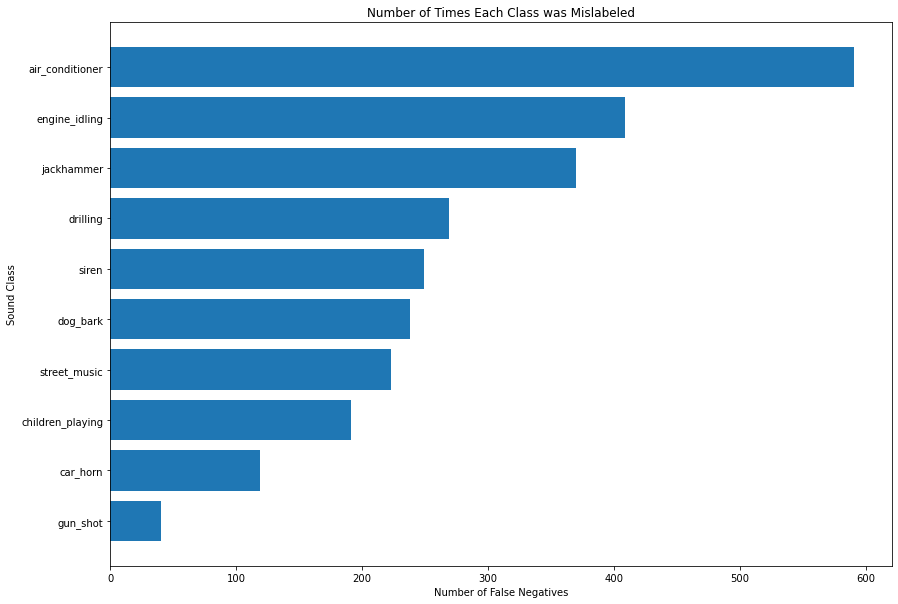

In [283]:
## visualize false_negatives
visualize_predictions(df, false_negatives=True)

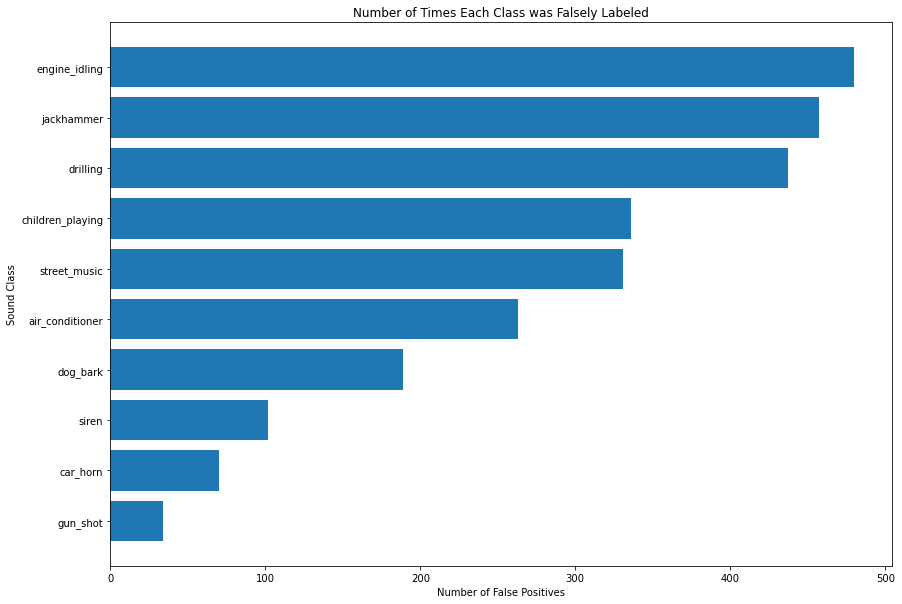

In [285]:
## visualize false_positives
visualize_predictions(df, false_positives=True)

It looks like air_conditioner is being predicted as engine idling a lot of the time. Let's listed to a few examples

In [33]:
import IPython.display as ipd

In [41]:
# example air conditioner
y_ac, sr = librosa.load('data/UrbanSound8K/audio/fold5/100852-0-0-0.wav', mono=True)
ipd.Audio('data/UrbanSound8K/audio/fold5/100852-0-0-0.wav')

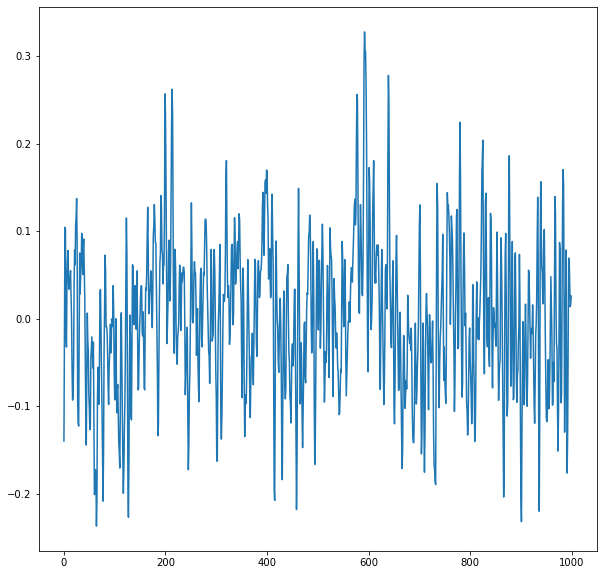

In [46]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(y_ac[2000:3000])

In [35]:
# example engine idle
y_engine, sr = librosa.load('data/UrbanSound8K/audio/fold10/102857-5-0-0.wav', mono=True)
ipd.Audio('data/UrbanSound8K/audio/fold10/102857-5-0-0.wav')

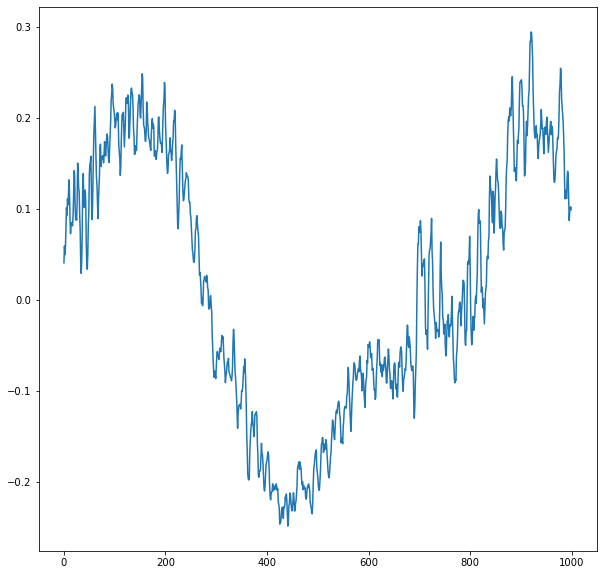

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(y_engine[0:1000])

### They are very similar, but the engine idling has some distinct differences. 

Can we design a feature that will improve our model?

### number of mfcc features

In [211]:
wrong_preds.head()

,actual_sound,predicted_sound,class_id_num,sound_id,fold


In [209]:
met = pd.read_csv('data/UrbanSound8K/metadata/UrbanSound8K.csv')
met[met['class'] == 'siren']

,slice_file_name,fsID,start,end,salience,fold,classID,class
114,102853-8-0-0.wav,102853,0.000000,4.000000,2,7,8,siren
115,102853-8-0-1.wav,102853,0.500000,4.500000,2,7,8,siren
116,102853-8-0-2.wav,102853,1.000000,5.000000,2,7,8,siren
117,102853-8-0-3.wav,102853,1.500000,5.500000,2,7,8,siren
118,102853-8-0-4.wav,102853,2.000000,6.000000,2,7,8,siren
...,...,...,...,...,...,...,...,...
8574,96657-8-0-1.wav,96657,122.837051,126.837051,2,8,8,siren
8575,96657-8-0-2.wav,96657,123.337051,127.337051,2,8,8,siren
8576,96657-8-0-3.wav,96657,123.837051,127.837051,2,8,8,siren
8642,98525-8-0-0.wav,98525,0.000000,4.000000,1,7,8,siren


In [178]:
diff = predicted_labels[0] - actual_labels[0]
diff[:20]

array([ 0,  0,  0,  0,  0,  6,  6,  6, -1,  0, -2, -2,  0,  0,  0,  0, -2,
        0,  0,  0])

In [179]:
diff[diff != 0] = 1
diff[:20]

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0])

TypeError: only integer scalar arrays can be converted to a scalar index

In [175]:
len(predicted_labels)

10

In [160]:
fold_acc

[0.6609392898052692,
 0.6970720720720721,
 0.6410810810810811,
 0.6383838383838384,
 0.7638888888888888,
 0.6585662211421628,
 0.6825775656324582,
 0.7034739454094293,
 0.7169117647058824,
 0.7801672640382318]

In [140]:
encoder1 = LabelEncoder()
encoder1.fit_transform(labels)

array([3, 2, 2, ..., 1, 1, 1])

In [141]:
labels

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

## Make NN Model

In [102]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from sklearn.model_selection import KFold, StratifiedKFold

feature_matrix, labels, folds

In [104]:
kf = KFold(n_splits=10)
skf = StratifiedKFold(n_splits=10)

In [106]:
print("Training",feature_matrix[0:100].shape)
print(labels[0:100].shape)
print("Validation",feature_matrix[100:110].shape)
print(labels[100:110].shape)
# print("Test",test_data.shape)
# print(test_label.shape)

Training (100, 82)
(100,)
Validation (10, 82)
(10,)


In [99]:
nn_model = Sequential()

nn_model.add(Dense(82, input_shape=(82,), activation = 'relu'))

nn_model.add(Dense(256, activation = 'relu'))
nn_model.add(Dropout(0.6))

nn_model.add(Dense(128, activation = 'relu'))
nn_model.add(Dropout(0.5))

nn_model.add(Dense(10, activation = 'softmax'))

nn_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [105]:
history = nn_model.fit(feature_matrix[0:100], labels[0:100], batch_size=64, epochs=30, 
                    validation_data=(feature_matrix[100:110], labels[100:110]))

Epoch 1/30


ValueError: in user code:

    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:748 train_step
        loss = self.compiled_loss(
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 10) are incompatible


In [100]:
nn_fold_acc = nn_model.train_kfold()

In [89]:
feature_matrix.shape

(8732, 82)

In [94]:
set(labels)

{'air_conditioner',
 'car_horn',
 'children_playing',
 'dog_bark',
 'drilling',
 'engine_idling',
 'gun_shot',
 'jackhammer',
 'siren',
 'street_music'}

In [95]:
model = Sequential()

model.add(Dense(82, input_shape=(82,), activation = 'relu'))

model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.6))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
features = []
for i in range(len(ton)):
    features.append(np.concatenate((me[i], mfc[i], 
                ton[i], chr[i]), axis=0))

In [109]:
me = [[1,2],[3,4]]
mfc = [[5,6],[7,8]]
ton = [[9, 10], [11, 12]]
chr = [[13, 14], [15, 16]]

In [110]:
features = []
for i in range(len(ton)):
    features.append(np.concatenate((me[i], mfc[i], 
                ton[i], chr[i]), axis=0))

In [111]:
features

[array([ 1,  2,  5,  6,  9, 10, 13, 14]),
 array([ 3,  4,  7,  8, 11, 12, 15, 16])]

------

# Create new wav files by adding two together:

In [113]:
metadata.head()

AttributeError: 'zip' object has no attribute 'head'